Import packages

In [ ]:
import pathlib
import numpy as np
import scanpy as sc
import pandas as pd

#pyscenic
import anndata as ad
from anndata.experimental.multi_files import AnnCollection

## This is T-SNE, download has wheel error, could fix... could use UM
#from MulticoreTSNE import MulticoreTSNE as TSNE

#data vis
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import umap

#scvi
import leidenalg
import igraph
import pymde
import torch
import tempfile
import scvi


In [14]:
import pathlib
current_directory = pathlib.Path.cwd()
module_directory = current_directory.parent.parent
input_path = module_directory / "input"
zip_path = input_path / "biostudiesarrayE-MTAB-14039"
extracted_path = input_path / "extracted_data"
hd5a_path = module_directory / 'hd5a_files'
scrna_metadata_path = input_path /"scRNA_metadata"
output_path = module_directory / 'output'
scrna_output = module_directory / 'output/integrated_scRNA'
other_output = output_path / 'scvi'
dataset_type = "heca_normal"

In [ ]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Total: {total // (2**30)} GiB")
print(f"Used: {used // (2**30)} GiB")
print(f"Free: {free // (2**30)} GiB")

In [ ]:

# Function to extract tar.gz files
def extract_tar_gz(tar_gz_path, extract_dir):
    with tarfile.open(tar_gz_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)

# Directory containing your datasets
  # Folder to save the extracted files
os.makedirs(extracted_path, exist_ok=True)

# List all top-level files in the input directory
tar_gz_files = [f for f in os.listdir(zip_path) if f.endswith('.tar.gz')]

# Extract tar.gz files
for tar_gz_file in tar_gz_files:
    tar_gz_path = os.path.join(zip_path, tar_gz_file)
    
    # Extract the tar.gz file to the extracted directory
    extract_tar_gz(tar_gz_path, extracted_path)


In [ ]:

# Directory where the files have been extracted
# List to store directory names under the 'work' directory
dataset_dirs = []

# Traverse the 'work' directory to find subdirectories
for root, dirs, files in os.walk(extracted_path):
    # Only consider directories directly under the 'work' directory
    if "work" in root:
        for dir_name in dirs:
            path = os.path.join(root, dir_name)
            # Append the directory name under 'work'
            dataset_dirs.append(path)

# Now dataset_dirs contains the names of all subdirectories under 'work'
print("Dataset directories under 'work':", dataset_dirs)


In [ ]:
print(dataset_dirs)


Docs: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anncollection.html
https://ccbskillssem.github.io/assets/scvi_notebook.html

warning: "If you use join='outer' this fills 0s for sparse data when variables are absent in a batch. Use this with care. Dense data is filled with NaN."

https://discourse.scverse.org/t/how-to-concatenate-anndata-properly/887/2
strongly recommends datacleaning each dataset before concatenating -- assuming that they did it for us

In [ ]:

if not os.path.exists(hd5a_path):
    os.makedirs(hd5a_path) 
combined_adatas_dict = {}
for directory in dataset_dirs:
   adata = sc.read_10x_mtx(directory)
    adata.X = adata.X.tocsr()
    #dir_name = directory.split("\\")[-1]
    dir_name = os.path.basename(directory) #platform independent
    h5ad_filename = f"{dir_name}.h5ad"

    h5ad_path = os.path.join(hd5a_path, h5ad_filename)
   combined_adata.write(h5ad_path)
    adatas_dict[dir_name] = h5ad_path


In [ ]:
print(adatas_dict)

In [ ]:

combined_on_disk_name = scrna_output/'data_combined_on_disk.h5ad'
#os.remove(combined_on_disk_name)
ad.experimental.concat_on_disk(
    adatas_dict,          # List of paths to the individual .h5ad files
    combined_on_disk_name,  # Path to the combined output file
    label='dataset'      # Optional: label for the datasets
)

In [ ]:
##METHOD USING BATCHING -- broken???
# # Directory where the files have been extracted
# extracted_work_dir = "input/extracted_data"  # Directory where you extracted the tar files
# # List to store directory names under the 'work' directory
# dataset_dirs = []

# # Traverse the 'work' directory to find subdirectories
# for root, dirs, files in os.walk(extracted_work_dir):
#     # Only consider directories directly under the 'work' directory
#     if "work" in root:
#         for dir_name in dirs:
#             path = os.path.join(root, dir_name)
#             # Append the directory name under 'work'
#             dataset_dirs.append(path)

# # Now dataset_dirs contains the names of all subdirectories under 'work'
# print("Dataset directories under 'work':", dataset_dirs)



# # List to store AnnData objects for merging
# adatas = []
# batch_size = 5  # Adjust based on available memory
# for i in range(0, len(dataset_dirs), batch_size):
#     # Get the current batch of files
#     batch_files = dataset_dirs[i:i+batch_size]
    
#     # Load the current batch of datasets
#     batch_adatas = []
#     for mtx_file in batch_files:
#         print(mtx_file)
#         # Assuming each batch is loaded from corresponding directories
#         adata = sc.read_10x_mtx(mtx_file)
#         batch_adatas.append(adata)
    
#     # Concatenate the current batch
#     if adatas:
#         adatas[0] = ad.concat([adatas[0]] + batch_adatas)
#         adatas[0].obs_names_make_unique() 
#     else:
#         adatas = batch_adatas

#     # Free memory by clearing the batch Adatas
#     batch_adatas = []

Load in data -- OLAF's VERSION. Garrett Depending on what you did you made need to make a different block.

Data Exploration

In [ ]:
combined_adata = sc.read(scrna_output/"heca_data_combined_on_disk.h5ad")
combined_adata.obs_names_make_unique()

d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
combined_adata.obs.head()


,dataset
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345


In [ ]:
import pandas as pd

#read text file into pandas DataFrame
df = pd.read_csv(scrna_metadata_path/'E-MTAB-14039.sdrf.txt', sep='\t', comment='#', on_bad_lines='skip')
#print(df.columns)
healthy_tissue = df[df['Characteristics[disease]'] == 'normal']['Source Name']

print(len(healthy_tissue))

32


In [9]:
#THIS WORKS BUT IS TOO SMALL
#combined_adata = combined_adata[~combined_adata.obs['dataset'].str.contains('Endo', na=False)]
combined_adata = combined_adata[combined_adata.obs['dataset'].isin(healthy_tissue)]
combined_adata.obs['dataset']

AAACCCAAGGCTTTCA-1      FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1      FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1      FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1      FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1      FRZFRESH_GX25_ES345
                              ...          
TTTGGTTGTTCTTCAT-1    UA_Endo9426400_FX1146
TTTGGTTTCACTCCGT-1    UA_Endo9426400_FX1146
TTTGGTTTCACTTGGA-1    UA_Endo9426400_FX1146
TTTGGTTTCCACGTCT-1    UA_Endo9426400_FX1146
TTTGGTTTCTCACTCG-1    UA_Endo9426400_FX1146
Name: dataset, Length: 135489, dtype: category
Categories (32, object): ['FRZFRESH_GX25_ES345', 'FRZFRESH_GX26_ES345', 'FRZFRESH_GX27_ES345', 'FRZFRESH_GX28_ES345', ..., 'UA_Endo12961682_SE03', 'UA_Endo13646709_SE06', 'UA_Endo9426399_FX1146', 'UA_Endo9426400_FX1146']

In [10]:
#from scipy import sparse

#sparse_X = sparse.csr_matrix(combined_adata.X)
#combined_adata.X = sparse_X

In [10]:


combined_adata.var.head()



""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3


In [11]:
print(combined_adata.var_names)
combined_adata.X

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 468435424 stored elements and shape (135489, 36601)>

In [12]:
combined_adata.obs
#output_file = "output/integrated_data.h5ad"
#combined_adata.write(output_file) # might just be failing because it already exists

,dataset
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345
...,...
TTTGGTTGTTCTTCAT-1,UA_Endo9426400_FX1146
TTTGGTTTCACTCCGT-1,UA_Endo9426400_FX1146
TTTGGTTTCACTTGGA-1,UA_Endo9426400_FX1146
TTTGGTTTCCACGTCT-1,UA_Endo9426400_FX1146


## Quality Control

In [13]:
combined_adata.var['MT'] = combined_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(combined_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)


combined_adata.obs.head()



C:\Users\Olaf\AppData\Local\Temp\ipykernel_29484\1254290072.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  combined_adata.var['MT'] = combined_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


,dataset,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345,3737,15451.0,1092.0,7.067504
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345,2225,4539.0,212.0,4.670632
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345,3379,11695.0,1544.0,13.202223
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345,2307,6950.0,700.0,10.071942
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345,2487,7820.0,658.0,8.414322


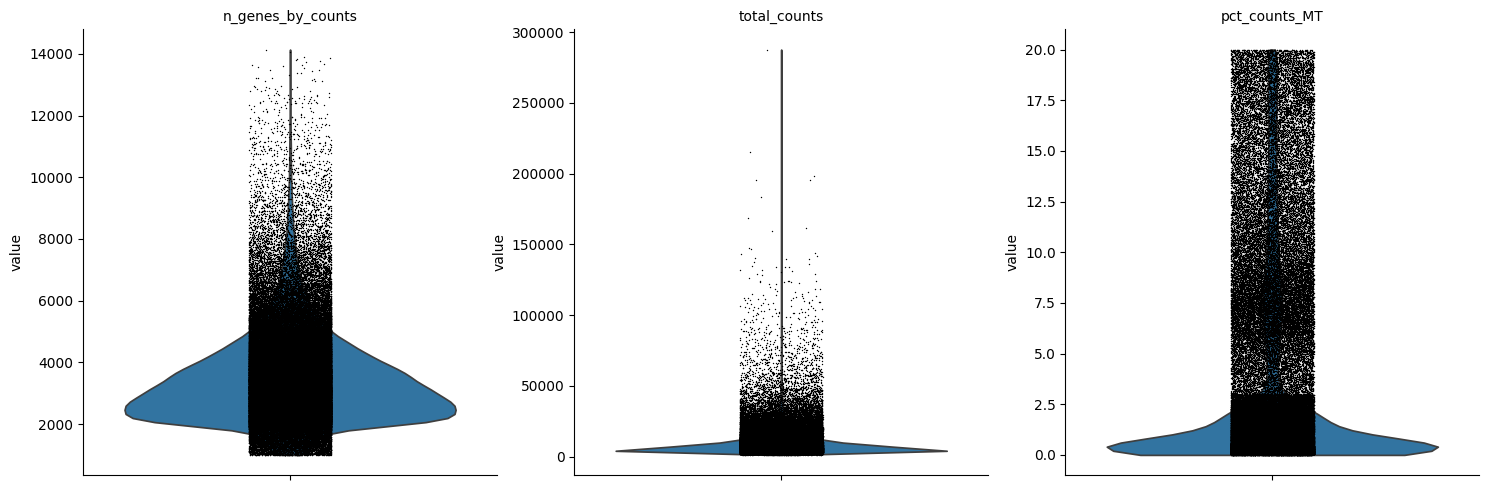

In [14]:
sc.pl.violin(
    combined_adata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True
)

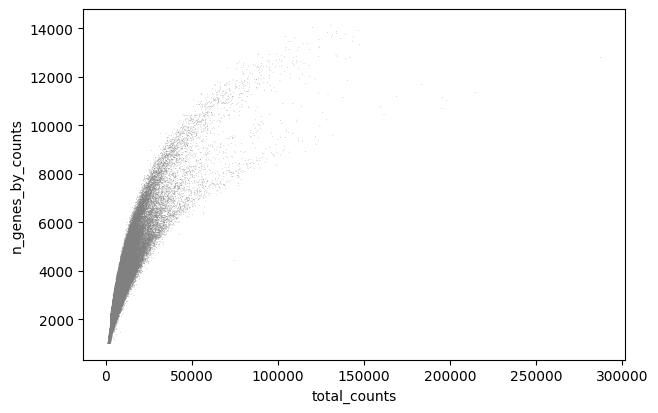

In [15]:
sc.pl.scatter(combined_adata, "total_counts", "n_genes_by_counts")

In [16]:
sc.pp.filter_cells(combined_adata, min_genes=100)
sc.pp.filter_genes(combined_adata, min_cells=3)

In [17]:
#skipping, I don't think doublets make sense to detect with dataset that has already been processed and integrated.
#sc.pp.scrublet(combined_adata, batch_key="sample")

In [18]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#combined_adata = sc.read("output/integrated_data.h5ad")

### Normalization

In [19]:
combined_adata.layers["counts"] = combined_adata.X.copy()
sc.pp.normalize_total(combined_adata, target_sum=1e4) 
sc.pp.log1p(combined_adata) 
combined_adata.raw = combined_adata

In [24]:
combined_adata.X.expm1().sum(axis = 1)

matrix([[10000.001],
        [10000.   ],
        [10000.001],
        ...,
        [10000.   ],
        [ 9999.998],
        [ 9999.999]], dtype=float32)

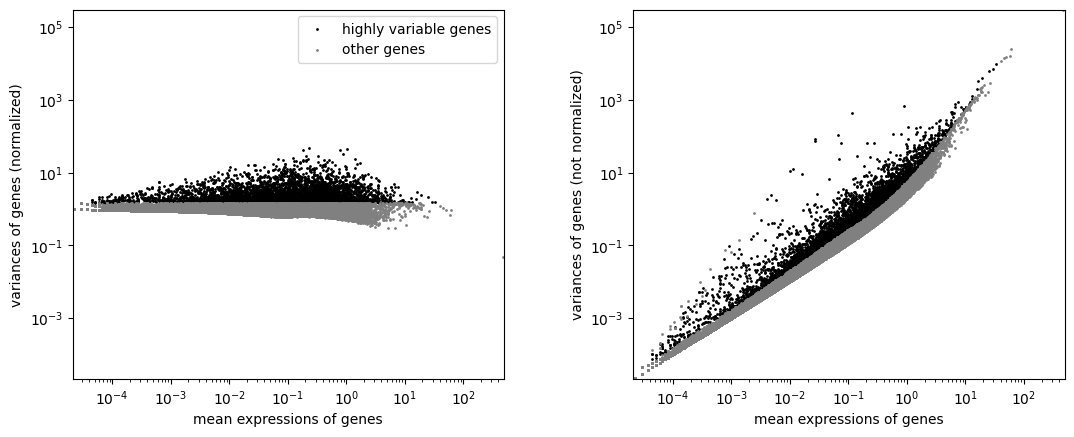

In [25]:
sc.pp.highly_variable_genes(
    combined_adata,
    n_top_genes=4000,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)
sc.pl.highly_variable_genes(combined_adata, log=True)

In [26]:
combined_adata = combined_adata[:, combined_adata.var.highly_variable].copy()
combined_adata.raw.to_adata()

AnnData object with n_obs × n_vars = 135489 × 34129
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'hvg'

In [27]:
combined_adata.var.columns

# The .var attribute stores metadata related to variables (typically genes). 
#view with specific with
## adata.var['gene_type'].head()


Index(['MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank',
       'means', 'variances', 'variances_norm'],
      dtype='object')

In [28]:
combined_adata.obs.columns
#The .obs attribute stores metadata related to the observations (cells). To see the available metadata columns:
#view with 
## adata.obs['cell_type'].head()

Index(['dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT',
       'pct_counts_MT', 'n_genes'],
      dtype='object')

In [29]:
combined_adata.uns.keys()
#The .uns attribute contains unstructured annotations that may include
#  clustering results, embeddings, or other metadata that doesn’t fit neatly into .obs or .var. 

odict_keys(['log1p', 'hvg'])

In [30]:
print(combined_adata.layers.keys())

KeysView(Layers with keys: counts)


### Standard Workflow

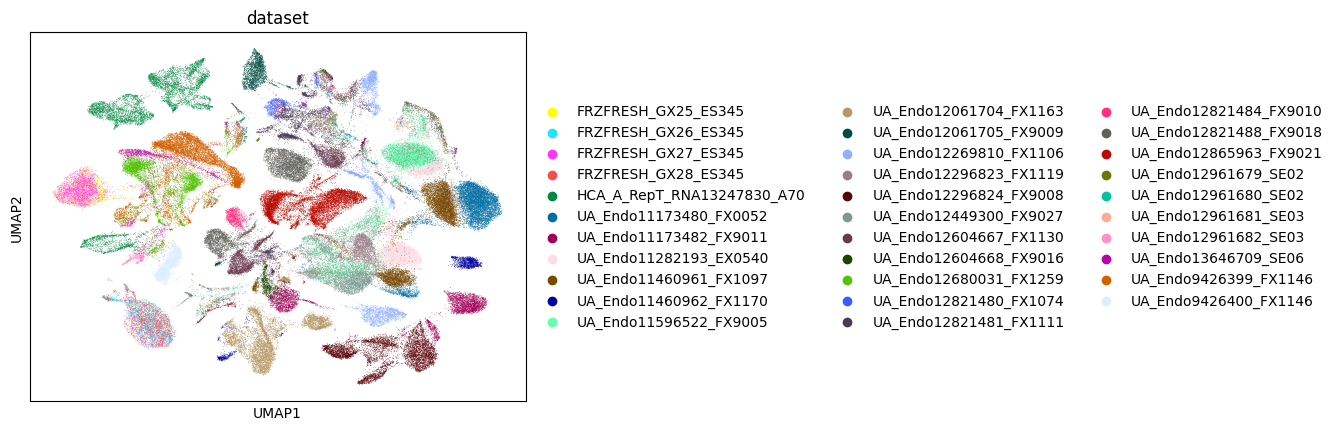

In [31]:
sc.pp.scale(combined_adata) # z normalize the columns (genes)
sc.tl.pca(combined_adata)


combined_adata.obsm["X_pca"]
sc.pp.neighbors(combined_adata) # compute nearest neighbors
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color="dataset")

 #combined_adata.X.expm1().sum(axis = 1)
doesn't work anymore because numpy.ndarray objects (used after scaling or PCA) do not have the .expm1() method. The .expm1() method is specifically for sparse matrices or objects that are compatible with this operation, and after scaling, you're working with a standard dense numpy.ndarray.

can try combined_adata.raw.X.expm1().sum(axis=1)    or    np.expm1(combined_adata.X).sum(axis=1) instead

IF THE CLUSTERS ARE BY BATCH:: ADD THIS CODE:

In [35]:

import scanpy.external as sce
sce.pp.bbknn(combined_adata, batch_key="dataset")
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color=["dataset"], ncols=1)
#don't know what this 'computation' warning is. No 'computation' parameter in bbknn or umap


KeyboardInterrupt: 

In [16]:
#combined_adata.write("output/combined_with_umap_no_scvi.h5ad")
combined_adata = sc.read(scrna_output/dataset_type/"combined_with_umap_no_scvi.h5ad")
combined_adata.obs.head()



,dataset,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT,n_genes,_scvi_batch,_scvi_labels
AAACCCAAGGCTTTCA-1,FRZFRESH_GX25_ES345,3737,15451.0,1092.0,7.067504,3737,0,0
AAACCCACAAGCTCTA-1,FRZFRESH_GX25_ES345,2225,4539.0,212.0,4.670632,2225,0,0
AAACCCAGTACGGTTT-1,FRZFRESH_GX25_ES345,3379,11695.0,1544.0,13.202223,3379,0,0
AAACCCAGTAGGACCA-1,FRZFRESH_GX25_ES345,2307,6950.0,700.0,10.071942,2307,0,0
AAACCCATCCCGAGGT-1,FRZFRESH_GX25_ES345,2487,7820.0,658.0,8.414322,2487,0,0


IF IT STILL DOESN'T WORK THEN REDO THE LOAD IN AND USE SCIVI
https://ccbskillssem.github.io/assets/scvi_notebook.html

https://www.youtube.com/watch?v=EKTg9NV5hEA

In [17]:

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
#save_dir = tempfile.TemporaryDirectory()
#%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
#%config InlineBackend.figure_format="retina"

In [18]:
!nvidia-smi

Wed Dec  4 17:47:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  |   00000000:02:00.0 Off |                  N/A |
|  0%   43C    P8             11W /  185W |    2293MiB /   8192MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:


print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
	
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

#Garrett if this is false for you -- 
## run this in powershell (assuming windows/pip/python): pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
## OR just comment out the next block rewrite it without the accelerator. It will take longer

Is CUDA supported by this system? True
CUDA version: 12.4
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce GTX 1070


In [20]:
scvi.settings.seed = 0
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


In [21]:

print(scvi.__version__)
# Set up the AnnData object (combined_adata)
scvi.model.SCVI.setup_anndata(combined_adata, layer="counts", batch_key='dataset')

# Initialize the SCVI model
model = scvi.model.SCVI(combined_adata) #, n_layers=2, n_latent=30, gene_likelihood="nb"

# Set the number of workers for data loading
scvi.settings.dl_num_workers = 0 #default is 0, gives warnings to raise but then gives iter(combined_loader) errors
# Train the model, specifying the accelerator (GPU or CPU)


1.2.0


In [22]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [23]:
print(str(combined_adata))
print(combined_adata.layers)

AnnData object with n_obs × n_vars = 135489 × 4000
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
Layers with keys: counts


In [ ]:
model.train() 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training:   0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
model_path = other_output/dataset_type/"_scvi_model"
model.save(model_path, overwrite=True)

In [ ]:
SCVI_LATENT_KEY = "X_scVI"

In [ ]:

combined_adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

NameError: name 'model' is not defined

In [ ]:
combined_adata.layers["scvi_expr"] = model.get_normalized_expression(combined_adata, n_samples=5, return_mean=True)

In [ ]:

sc.pp.neighbors(combined_adata, use_rep="X_scvi", metric="correlation")

ValueError: Did not find X_scvi in `.obsm.keys()`. You need to compute it first.

In [ ]:

sc.tl.leiden(combined_adata, key_added="leiden_scvi", resolution=1.2)

In [ ]:

sc.tl.umap(combined_adata, min_dist=0.4)

In [ ]:
SCVI_MDE_KEY = "X_scVI_MDE"
combined_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(combined_adata.obsm[SCVI_LATENT_KEY]) #last run was with , accelerator="cpu" but I removed this so that it can use gpu, return if breaks

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


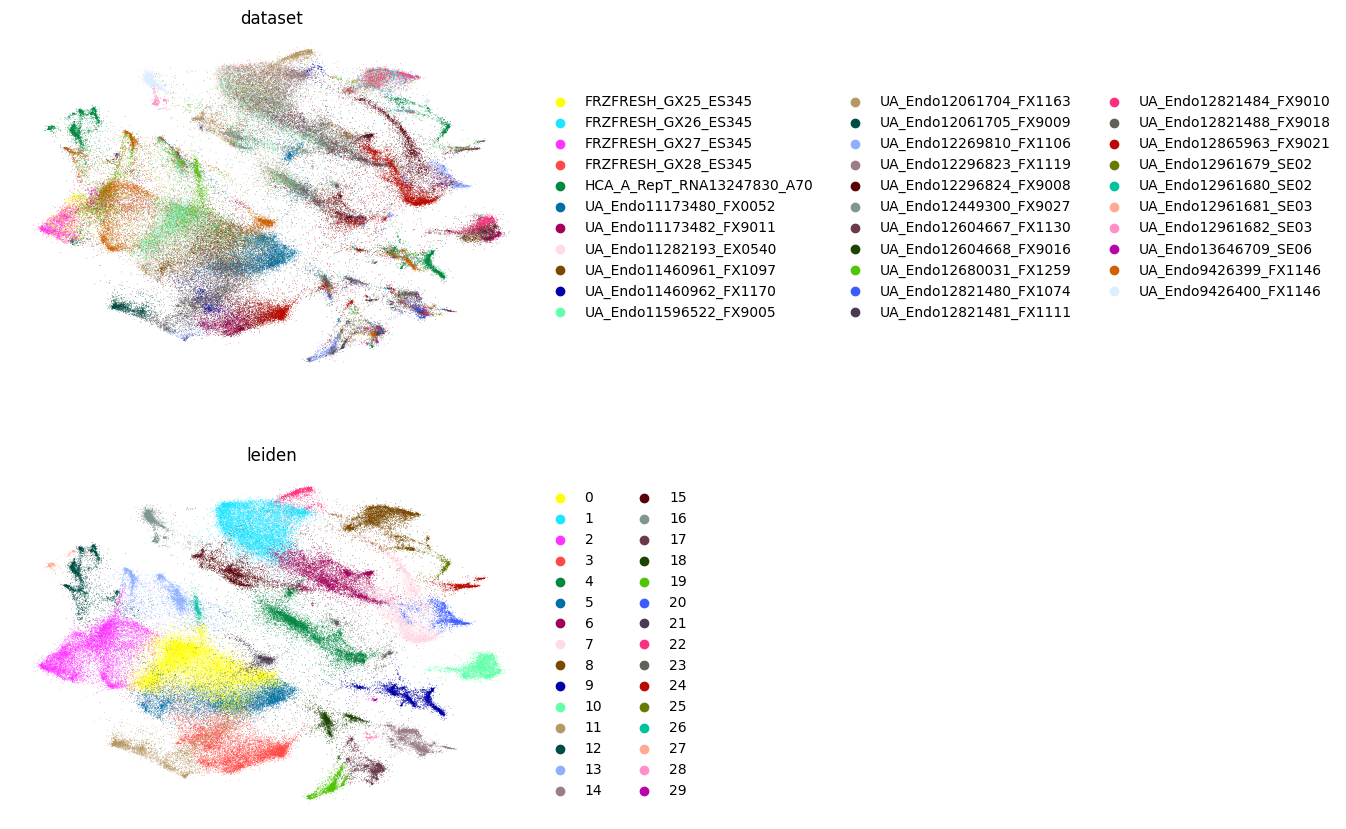

In [ ]:
sc.pl.embedding(
    combined_adata,
    basis=SCVI_MDE_KEY,
    color=["dataset", "leiden"],
    frameon=False,
    ncols=1,
)

In [ ]:
#raise KeyboardInterrupt

In [ ]:
output_file = scrna_output/dataset_type/"scvi_integrated.h5ad"
#combined_adata.write(output_file)
#combined_adata = sc.read(output_file)


In [ ]:
str(combined_adata)

"AnnData object with n_obs × n_vars = 135489 × 4000\n    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'\n    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'\n    uns: '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'\n    obsm: 'X_pca', 'X_scVI', 'X_scVI_MDE', 'X_umap'\n    varm: 'PCs'\n    layers: 'counts'\n    obsp: 'connectivities', 'distances'"

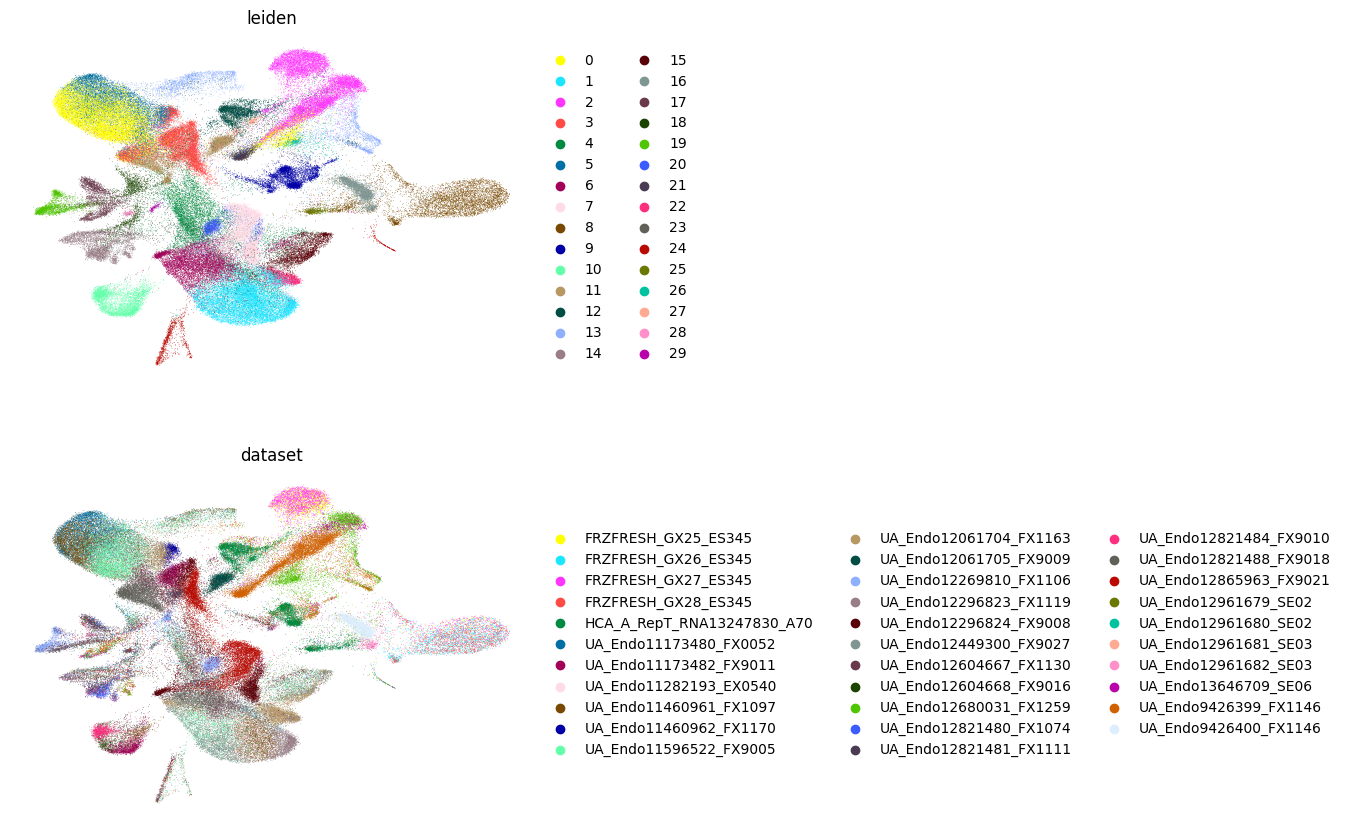

In [ ]:

#result of umap compared to previous scvi embedding 
sc.pl.umap(
   combined_adata,
    color=["leiden", 'dataset'],
    frameon=False,
    ncols=1
)



In [ ]:
full_de_res = model.differential_expression(groupby='leiden_subclusters')
full_de_res.head()

NameError: name 'model' is not defined

In [ ]:
de_btwn_groups = model.differential_expression(groupby='leiden_subclusters', group1 = "CD4 T" , group2 = "CD8 T")
de_btwn_groups.head()

In [ ]:
de_btwn_groups = model.differential_expression(groupby='cell_types', group1 = "CD4 T")
de_btwn_groups.head()

In [ ]:


sc.tl.rank_genes_groups(combined_adata, groupby="cell_types")



In [ ]:
sc.get.rank_genes_groups_df(combined_adata, group="Tregs")

In [ ]:
markers = {}
cats = combined_adata.obs.cell_types.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = full_de_res.loc[full_de_res.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_mean", ascending=False)

    # those genes with higher expression in group 1
    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    # significance
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    # genes with sufficient expression
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [ ]:
sc.tl.dendrogram(combined_adata, groupby="cell_types", use_rep="X_scvi")

In [ ]:


sc.pl.dotplot(
   combined_adata,
    markers,
    groupby='cell_types',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)



In [ ]:
sc.pl.matrixplot(
   combined_adata, 
    markers, 
    groupby='cell_types',
    standard_scale="var",
    layer="scvi_expr",
    dendrogram=True,
)

In [ ]:
sc.pl.rank_genes_groups_stacked_violin(combined_adata, n_genes=2)

In [ ]:


sc.pl.umap(combined_adata, color=["Ly6d", "Xcr1", "Foxp3"])
sc.pl.umap(combined_adata, color=["Ly6d", "Xcr1", "Foxp3"], layer="scvi_expr")



In [ ]:


sc.tl.embedding_density(combined_adata, groupby="tissue", key_added="tissue_density")



In [ ]:
sc.pl.umap(combined_adata, color=["cell_types", "tissue"], ncols=1)

In [ ]:
sc.pl.embedding_density(combined_adata, key="tissue_density")